In [ ]:
from __future__ import unicode_literals
import requests
import json
import csv
import matplotlib.pyplot as plt
from sets import Set
import numpy as np
import cPickle
import utils
from difflib import SequenceMatcher
import pandas as pd
import skimage
from sklearn.feature_extraction.text import TfidfVectorizer
import re

from scipy.spatial.distance import cosine

%matplotlib inline
import seaborn as sns
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.75, 's' : 120, 'linewidths':0}

%load_ext autoreload
%autoreload 2
import base64
from PIL import Image
from itertools import izip
import os
import random

import hashlib
from sklearn.metrics.pairwise import cosine_similarity
import glob
from collections import Counter

import sys
import time
from multiprocessing import Pool
#stdout = sys.stdout
#reload(sys)
#sys.setdefaultencoding('utf-8')
#sys.stdout = stdout

In [1]:
pwd

u'/mnt/cephfs/hadoop-compute/phoenix/ting/wisdom'

In [51]:
!hostname

dswa069-dca1


---

# nlp basics

In [52]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.nist import NISTTokenizer
nist = NISTTokenizer()

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

import nltk
nltk.download('stopwords')
nltk.download('perluniprops')

sno = nltk.stem.SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/udocker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/udocker/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!


In [53]:
def jaccard_dist(a,b):
    return float(len(a&b))/float(len(a|b))

In [54]:
def ngrams(string, n=3):
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

## keywords for user_input / description

In [ ]:
descr = ""
filelist = glob.glob("./task_content_train/*")
for f in filelist:
    with open(f) as json_file:  
        data = json.load(json_file)
        if 'hits' in data:
            if 'hits' in data['hits']:
                for d in data['hits']['hits']:
                    if 'phabId' in d['_source']:
                        if d['_source']['userInput'] is not None:
                            descr = descr+ d['_source']['userInput'].encode("utf-8").decode('utf8', 'ignore')

In [ ]:
len(descr)

In [12]:
def pre_processing(descr,stop_words):
    lowers = descr.lower()
    tokens = tokenizer.tokenize(lowers)
    
    filtered_words = []
    for w in tokens:
        if w not in stop_words:
            #w = sno.stem(w)
            filtered_words.append(w)
    return filtered_words

In [ ]:
tokens = pre_processing(descr,stop_words)

In [ ]:
count = Counter(tokens)

In [ ]:
len(count)

#### top 500 keywords

In [ ]:
keyword = []
for l in count.most_common(500):
    print l
    keyword.append(l[0])

In [ ]:
def get_descr_feature(keyword, tokens):
    c = {}
    for k in keyword:
        c[k] = 0
    count = Counter(tokens)
    interkey = list(set(keyword).intersection(count.keys()))
    #print interkey
    for ik in interkey:
        c[ik] = count[ik]
    #print c
    feature = []
    for key, value in c.iteritems():
        feature.append(value)
    feature = np.array(feature).reshape(1,-1)
    return feature

---

# word 2 vec

In [1]:
from gensim.models import Word2Vec
from nltk.corpus import brown, movie_reviews, treebank

In [2]:
gmodel = Word2Vec.load_word2vec_format('../RiskDS2018/u4b/GoogleNews-vectors-negative300.bin', binary=True)  

In [13]:
descr_sents = []
filelist = glob.glob("./task_content_train/*")
for f in filelist:
    with open(f) as json_file:  
        data = json.load(json_file)
        if 'hits' in data:
            if 'hits' in data['hits']:
                for d in data['hits']['hits']:
                    if 'phabId' in d['_source']:
                        if d['_source']['userInput'] is not None:
                            strs = d['_source']['userInput'].encode("utf-8").decode('utf8', 'ignore')
                            tokens = pre_processing(strs,stop_words)
                            descr_sents.append(tokens)

In [14]:
len(descr_sents)

9122

In [15]:
filelist = glob.glob("./task_content_train/*")
for f in filelist:
    with open(f) as json_file:  
        data = json.load(json_file)
        if 'hits' in data:
            if 'hits' in data['hits']:
                for d in data['hits']['hits']:
                    if 'phabId' in d['_source']:
                        if d['_source']['userInput'] is not None:
                            strs = d['_source']['userSummary'].encode("utf-8").decode('utf8', 'ignore')
                            tokens = pre_processing(strs,stop_words)
                            descr_sents.append(tokens)

In [16]:
len(descr_sents)

18244

In [33]:
w2v_model = Word2Vec(descr_sents,size=150, window=20, min_count=3)

In [19]:
print len(w2v_model['uber']) 

100


In [48]:
gmodel.similar_by_word('payment', 10)

[(u'payments', 0.842191219329834),
 (u'Payment', 0.6990829706192017),
 (u'repayment', 0.6493304371833801),
 (u'Payments', 0.6373319029808044),
 (u'repayments', 0.5662027597427368),
 (u'pay', 0.5520696640014648),
 (u'prepayment', 0.5418148636817932),
 (u'monthly_installments', 0.5385578870773315),
 (u'BPay', 0.5364115834236145),
 (u'borrower_repays', 0.5358425378799438)]

In [46]:
w2v_model.similar_by_word('car', 10)

[(u'dispatched', 0.9990038871765137),
 (u'originally', 0.9983204007148743),
 (u'driver', 0.9981591105461121),
 (u'matched', 0.9975348114967346),
 (u'arrived', 0.9974392056465149),
 (u'waited', 0.9973636865615845),
 (u'save', 0.9973622560501099),
 (u'match', 0.9973022937774658),
 (u'jumps', 0.9971593618392944),
 (u'5min', 0.9970822334289551)]

In [ ]:
def get_w2v_dist(tokens1, tokens2, w2v_model):
    
    if (len(tokens1)>0 and len(tokens2)>0):
        word_vectors = w2v_model.wv
        s1 = np.zeros(100)
        for t1 in tokens1:
            if t1 in word_vectors.vocab:
                s1 = s1 + w2v_model[t1]
        s1 = s1/len(tokens1)

        s2 = np.zeros(100)
        for t2 in tokens2:
            if t2 in word_vectors.vocab:
                s2 = s2 + w2v_model[t2]
        s2 = s2/len(tokens2)


        d2 = cosine(s1,s2)

        t1_dict = []
        for w in tokens1:
            if w in word_vectors.vocab:
                l = w2v_model.similar_by_word(w, 10)
                for i in l:
                    t1_dict.append(i[0])
        t1_dict = t1_dict + tokens1

        ct1 = 0
        for w in tokens2:
            if w in t1_dict:
                ct1 = ct1 +1;

        t2_dict = []
        for w in tokens2:
            if w in word_vectors.vocab:
                l = w2v_model.similar_by_word(w, 10)
                for i in l:
                    t2_dict.append(i[0])
        t2_dict = t2_dict + tokens2

        ct2 = 0
        for w in tokens1:
            if w in t2_dict:
                ct2 = ct2 +1;
            
        return [d2, float(ct1)/float(len(tokens2)), float(ct2)/float(len(tokens1))]
    else:
        return [0,0,0]

In [ ]:
def plot_sent(s):
    token = descr_preprocess(s,w2v_model)
    X = w2v_model[token]
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)
    df = pd.DataFrame(X_tsne, index=token, columns=['x', 'y'])
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(df['x'], df['y'], c='r')
    for word, pos in df.iterrows():
        ax.annotate(word, pos)

## data preprocessing

In [55]:
# 1-5 2018 snaptask tickets from ELK

data_dict = {}
filelist = glob.glob("./task_content/*")
for f in filelist:
    with open(f) as json_file:  
        data = json.load(json_file)
        if 'hits' in data:
            if 'hits' in data['hits']:
                for d in data['hits']['hits']:
                    if 'phabId' in d['_source']:
                        data_dict[d['_source']['phabId'][1:]] = d['_source']

In [56]:
len(data_dict)

15996

## create feature

In [57]:
def string_matcher(str1, str2): 
    nstr1 = set(ngrams(str1,3)+ngrams(str1,2)+ngrams(str1,1))
    nstr2 = set(ngrams(str2,3)+ngrams(str2,2)+ngrams(str2,1))
      
    if len(nstr1)>0 or len(nstr2)>0:
        return jaccard_dist(nstr1,nstr2)
    elif len(nstr1)==0 and len(nstr1)==0:
        return 1
    else:
        return 0

In [58]:
def os_version_preprocess(os):
    os = os.replace('(','')
    os = os.replace(')','')
    os = os.lower()
    os = nist.tokenize(os)
    return os

In [59]:
def get_content_snap(data_dict,ids):
    result = {}
    report_id = ids
    content = data_dict[ids]
    
    create_at = ''
    if 'created' in content:
        created_at = content['created']
    
    feature_descr = ''
    if 'featureDescr' in content:
        feature_descr = content['featureDescr']
        
    device_model = ''
    if 'deviceModel' in content:
        device_model = content['deviceModel']
        
    city_id = ''
    if 'city_id' in content:
        city_id = content['city_id']
        
    app_name = '' 
    if 'app' in content:
        app_name = content['app']
        
    user_uuid = ''
    if 'userUuid' in content:
        user_uuid = content['userUuid']
    
    user_input = ''
    if 'userInput' in content:
        user_input = content['userInput']
        if user_input is None:
            user_input = ''
        
    user_summary = ''
    if 'userSummary' in content:
        user_summary = content['userSummary']
        if user_summary is None:
            user_summary = ''
        
        
    os_version = ''
    if 'os' in content:
        os_version = content['os']
    
    app_version = ''
    if 'version' in content:
        app_version = content['version']
    
    descr = ''
    if 'systemDescription' in content:
        descr = content['systemDescription']
        
    locale = ''
    if 'locale' in content:
        locale = content['locale']
    
    rst = {}
    rst['report_id'] = report_id
    rst['created_at'] = created_at
    rst['feature_descr'] = feature_descr
    rst['device_model'] = device_model
    rst['city_id'] = city_id
    rst['app_name'] = app_name
    rst['user_uuid'] = user_uuid
    rst['user_input'] = user_input
    rst['user_summary'] = user_summary
    rst['os_version'] = os_version
    rst['app_version'] = app_version
    rst['descr'] = descr
    rst['locale'] = locale

    return rst

In [60]:
def app_name_preprocess(appname):
    appname_list = ['carbon', 'driver', 'helix', 'helix uber', 'uberdriver']
    if appname not in appname_list:
        appname = 'other'
    if appname == 'uberdriver':
        appname = 'carbon'
    return appname

In [61]:
 def get_match_score(t):
    t1 = t[0]
    t2 = t[1]
    
    input_match = string_matcher(t1['user_input'], t2['user_input'])
    summary_match = string_matcher(t1['user_summary'], t2['user_summary'])
    featureDesc_match = string_matcher(t1['feature_descr'], t2['feature_descr'])
    create_diff = abs(int(t1['created_at'])-int(t2['created_at']))
    
    if t1['device_model'] == t2['device_model']:
        same_device_model = 1
    else:
        same_device_model = 0
    
    t1_appname = app_name_preprocess(t1['app_name'])
    t2_appname = app_name_preprocess(t2['app_name'])
    
    if t1_appname == t2_appname:
        same_app = 1
    else:
        same_app = 0
        
    if t1['user_uuid'] == t2['user_uuid']:
        same_user = 1
    else:
        same_user = 0
        
    appV1 = t1['app_version']
    appV2 = t2['app_version']
    same_appV1=0
    same_appV2=0
    same_appV3=0
    if len(appV1)==len(appV2):
        appV11 = appV1.split('.')
        appV22 = appV2.split('.')
        if appV11[0] == appV22[0]:
            same_appV1 = 1
        if (appV11[0] == appV22[0]) and (appV11[1] == appV22[1]) :
            same_appV2 = 1    
        if (appV11[0] == appV22[0]) and (appV11[1] == appV22[1]) and (appV11[2] == appV22[2])  :
            same_appV3 = 1
    
    same_os1 = 0
    same_os2 = 0
    os1 = os_version_preprocess(t1['os_version'])
    os2 = os_version_preprocess(t2['os_version'])
    if (len(os1) == len(os2))and (len(os1)==2):
        if os1[0] == os2[0]:
            same_os1 = 1
        if (os1[0] == os2[0]) and (os1[1] == os2[1]):
            same_os2 = 1
    
    same_city = 0
    if t1['city_id'] == t2['city_id']:
        same_city = 1 
    
    same_locale = 0
    if t1['locale'] == t2['locale']:
        same_locale = 1 
        
 
    #token1 = pre_processing(t1['user_input'],stop_words)
    #token2 = pre_processing(t2['user_input'],stop_words)
    #k1 = get_descr_feature(keyword, token1)
    #k2 = get_descr_feature(keyword, token2)
    
    #system_match = cosine_similarity(k1,k2)[0][0]
    #[d1,d2,d3] = get_w2v_dist(token1, token2, w2v_model)
    
    #token1 = pre_processing(t1['user_summary'],stop_words)
    #token2 = pre_processing(t2['user_summary'],stop_words)
    #[d4,d5,d6] = get_w2v_dist(token1, token2, w2v_model)
        
    return t1['report_id'], t2['report_id'], input_match, summary_match, featureDesc_match,create_diff, same_device_model,\
            same_app, same_user, same_appV1, same_appV2, same_appV3, same_os1, same_os2, same_city,same_locale

## score duplicated pair

In [62]:
dup_pairs = cPickle.load(open('1-5_2018_duplicated_pairs.p', 'rb'))

In [63]:
df = pd.DataFrame.from_records(dup_pairs, columns=['task1','task2'])

In [64]:
len(df)

4659

In [65]:
df.head(3)

,task1,task2
0,1759453,1759451
1,1713183,1713187
2,1544663,1544665


In [66]:
df_dups = set(df['task1'].tolist() + df['task2'].tolist())
print "total number of tickets that have dups in 1-5 2018: ", len(df_dups)

total number of tickets that have dups in 1-5 2018:  5583


In [67]:
df_task = set(data_dict.keys())
print "total number of tickets from snap task in 1-5 2018: ", len(df_task)

total number of tickets from snap task in 1-5 2018:  15996


In [68]:
df_all = df_task.intersection(df_dups)
print "total number of tickets that have dups from snap task in 1-5 2018: ", len(df_all)

total number of tickets that have dups from snap task in 1-5 2018:  4788


In [69]:
df = df[(df['task1'].isin(list(df_all))) & (df['task2'].isin(list(df_all)))]

In [70]:
print "total number dup pairs in 1-5 2018: ", len(df)

total number dup pairs in 1-5 2018:  3350


In [71]:
def compute_feature_for_pair(df,data_dict):
    d1 = df['task1'].tolist()
    d2 = df['task2'].tolist()
    rst = []
    ct = 0
    for p1,p2 in zip(d1,d2):
        if ct%10000 == 0:
            print ct, len(d1)
        ct = ct +1
        t = [get_content_snap(data_dict, p1), get_content_snap(data_dict, p2)]
        #print p1,p2
        v = get_match_score(t)
        rst.append(v)
        
    df_rst = pd.DataFrame.from_records(rst, columns=['task1','task2','input_match','summary_match','featureDesc_match','create_diff',\
                                           'same_device_model','same_app','same_user','same_appV1','same_appV2','same_appV3',\
                                           'same_os1','same_os2','same_city','same_locale'])    
        
    return df_rst

In [72]:
df_same = compute_feature_for_pair(df,data_dict)

0 3350


# analysis

In [73]:
df_same[(df_same.same_os1==1) & (df_same.same_app==1) ].count().task1

2602

In [74]:
df_same.count().task1

3350

In [75]:
float(2602)/float(3350)

0.7767164179104478

In [76]:
d1 = df['task1'].tolist()
d2 = df['task2'].tolist()
d = list(set(d1+d2))
rst = []
for p in d:
    t = get_content_snap(data_dict, p)
    rst.append([p, t['app_name'], t['app_version'], t['city_id'], t['created_at'], t['descr'], t['device_model'], t['feature_descr'], t['locale'], t['os_version'], t['report_id'], t['user_input'], t['user_summary'], t['user_uuid']])
df_rst = pd.DataFrame.from_records(rst, columns = ['task_id', 'app_name', 'app_version','city_id', 'created_at', 'descr','device_model', 'feature_descr', 'locale','os_version', 'report_id', 'user_input', 'user_summary', 'user_uuid'])

In [77]:
df_rst['os_type'] = df_rst.apply(lambda row: os_version_preprocess(row['os_version'])[0], axis=1)

In [78]:
df_rst[['task_id','app_name']].groupby(['app_name']).count()

,task_id
app_name,
carbon,214
driver,89
fleet,3
helix,2561
helix uber,783
helix uber exo,6
uberdriver,410
ubernav,4
ubernav build date: jan 5 2018,2


In [79]:
df_rst[['task_id','os_type']].groupby(['os_type']).count()

,task_id
os_type,
android,885
ios,3189


In [80]:
df_rst[['task_id','app_name', 'os_type']][df_rst.app_name.isin(['carbon', 'driver', 'helix', 'helix uber', 'uberdriver'])].groupby(['app_name','os_type']).count()

,,task_id
app_name,os_type,
carbon,ios,214
driver,android,89
helix,ios,2561
helix uber,android,783
uberdriver,ios,410


## create random pair

In [81]:
d1 = df['task1'].tolist()
d2 = df['task2'].tolist()

In [82]:
random_list = []
for i in range(10000):
    p = random.sample(set(d1+d2), 2)
    if (df[(df['task1']==p[0]) & (df['task2']==p[1])].empty) \
       and (df[(df['task2']==p[0]) & (df['task1']==p[1])].empty):
        random_list.append(p)
df_random = pd.DataFrame.from_records(random_list, columns=['task1','task2'])   

In [83]:
df_random.shape

(9995, 2)

In [84]:
df_random.head(3)

,task1,task2
0,1698341,1522665
1,1800825,1646045
2,1682539,1705731


In [85]:
df_diff = compute_feature_for_pair(df_random,data_dict)

0 9995


In [86]:
df_diff[(df_diff.same_os1==1) & (df_diff.same_app==1)].count().task1

4628

---

In [87]:
df_same = df_same[(df_same.same_os1==1) & (df_same.same_app==1)]
df_diff = df_diff[(df_diff.same_os1==1) & (df_diff.same_app==1)]

## classification

In [88]:
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve,average_precision_score

In [89]:
len(df_diff)

4628

In [90]:
len(df_same)

2602

In [91]:
tasks_same = list(set(df_same.task1.values.tolist() + df_same.task2.values.tolist()))
task_same_test = random.sample(tasks_same, 500)
df_same_train = df_same[(~df_same.task1.isin(task_same_test))&(~df_same.task2.isin(task_same_test))]
df_same_test = df_same[(df_same.task1.isin(task_same_test))|(df_same.task2.isin(task_same_test))]

In [92]:
tasks_diff = list(set(df_diff.task1.values.tolist() + df_diff.task2.values.tolist()))
task_diff_test = random.sample(tasks_diff, 500)
df_diff_train = df_diff[(~df_diff.task1.isin(task_diff_test))&(~df_diff.task2.isin(task_diff_test))]
df_diff_test = df_diff[(df_diff.task1.isin(task_diff_test))|(df_diff.task2.isin(task_diff_test))]

In [93]:
print len(df_same_train), len(df_same_test), len(df_diff_train), len(df_diff_test)

1936 666 3330 1298


In [94]:
data_sim_train = df_same_train[['input_match','summary_match','featureDesc_match','create_diff',\
                    'same_device_model','same_user','same_appV1','same_appV2','same_appV3',\
                    'same_city','same_locale']]
data_sim_test = df_same_test[['input_match','summary_match','featureDesc_match','create_diff',\
                    'same_device_model','same_user','same_appV1','same_appV2','same_appV3',\
                    'same_city','same_locale']]

In [95]:
data_random_train = df_diff_train[['input_match','summary_match','featureDesc_match','create_diff',\
                    'same_device_model','same_user','same_appV1','same_appV2','same_appV3',\
                    'same_city','same_locale']]

data_random_test = df_diff_test[['input_match','summary_match','featureDesc_match','create_diff',\
                    'same_device_model','same_user','same_appV1','same_appV2','same_appV3',\
                    'same_city','same_locale']]

In [96]:
corr_matrix = data_sim_train.corr().abs()

In [97]:
data_sim_train = data_sim_train.fillna(0)
data_random_train = data_random_train.fillna(0)
data_sim_test = data_sim_test.fillna(0)
data_random_test = data_random_test.fillna(0)
X_sim_train = data_sim_train.as_matrix()
X_random_train = data_random_train.as_matrix()
X_sim_test = data_sim_test.as_matrix()
X_random_test = data_random_test.as_matrix()

X_train = np.vstack((X_sim_train, X_random_train))
X_test = np.vstack((X_sim_test, X_random_test))

labels_train = np.hstack((np.ones(X_sim_train.shape[0]), np.zeros(X_random_train.shape[0])))
y_train = labels_train.astype(int)

labels_test = np.hstack((np.ones(X_sim_test.shape[0]), np.zeros(X_random_test.shape[0])))
y_test = labels_test.astype(int)
print y_train.shape, y_test.shape

#X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

(5266,) (1964,)


In [98]:
lrcf = LogisticRegression()
lrcf.fit(X_train_transformed, y_train)
lrcf.score(X_test_transformed, y_test)

0.85183299389002032

Average precision-recall score: 0.84


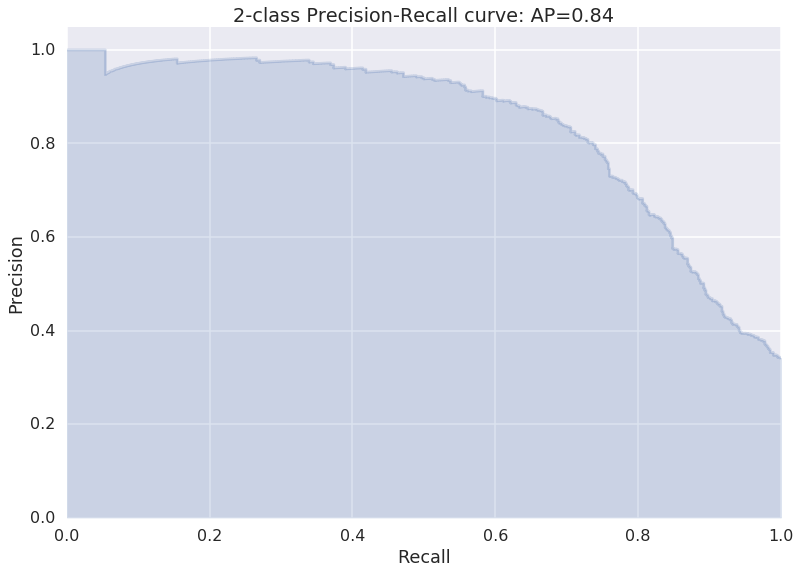

In [99]:
y_score = lrcf.decision_function(X_test_transformed)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

([<matplotlib.axis.XTick at 0x7f54643dded0>,
 <a list of 11 Text xticklabel objects>)

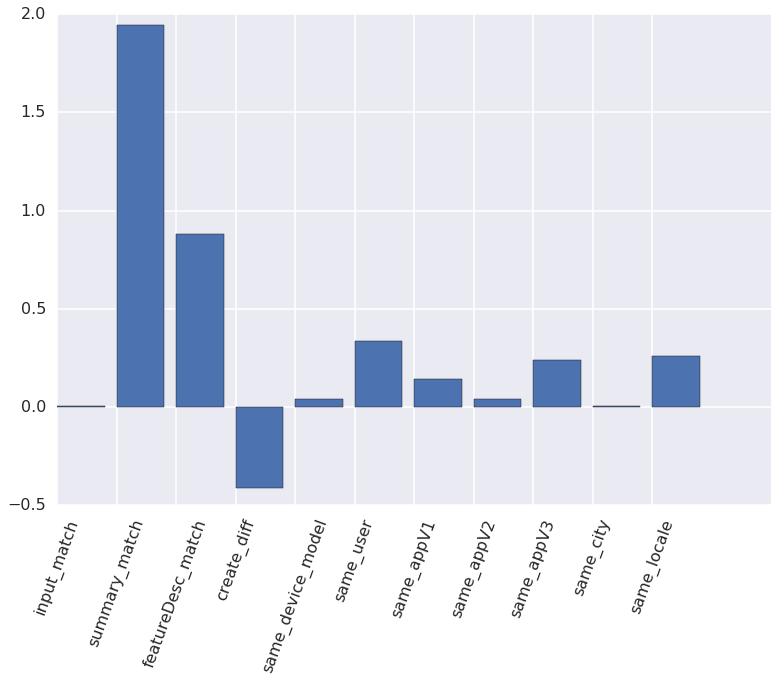

In [100]:
feature_names = ['input_match','summary_match','featureDesc_match','create_diff',\
                    'same_device_model','same_user','same_appV1','same_appV2','same_appV3',\
                    'same_city','same_locale']
coef = lrcf.coef_.ravel()
plt.figure()
plt.bar(np.arange(len(feature_names)), coef)
plt.xticks(np.arange(len(feature_names)), feature_names, rotation=70)

# testing and clustering

In [107]:
# 6,7,8 2018 snaptask tickets from ELK

data_dict_test = {}
filelist = glob.glob("./task_content_train/task_content_7_*-2018.txt")
for f in filelist:
    with open(f) as json_file:  
        data = json.load(json_file)
        if 'hits' in data:
            if 'hits' in data['hits']:
                for d in data['hits']['hits']:
                    if 'phabId' in d['_source']:
                        data_dict_test[d['_source']['phabId'][1:]] = d['_source']

In [108]:
len(data_dict_test)

2515

In [109]:
df_test = []
testIdList = data_dict_test.keys()
for i in range(len(testIdList)):
    for j in range(i+1,len(testIdList)):
        df_test.append([str(testIdList[i]),str(testIdList[j])])

In [110]:
df_test = pd.DataFrame.from_records(df_test, columns=['task1','task2'])    
len(df_test)

3161355

In [111]:
df_test_feature = compute_feature_for_pair(df_test,data_dict_test)

0 3161355
10000 3161355
20000 3161355
30000 3161355
40000 3161355
50000 3161355
60000 3161355
70000 3161355
80000 3161355
90000 3161355
100000 3161355
110000 3161355
120000 3161355
130000 3161355
140000 3161355
150000 3161355
160000 3161355
170000 3161355
180000 3161355
190000 3161355
200000 3161355
210000 3161355
220000 3161355
230000 3161355
240000 3161355
250000 3161355
260000 3161355
270000 3161355
280000 3161355
290000 3161355
300000 3161355
310000 3161355
320000 3161355
330000 3161355
340000 3161355
350000 3161355
360000 3161355
370000 3161355
380000 3161355
390000 3161355
400000 3161355
410000 3161355
420000 3161355
430000 3161355
440000 3161355
450000 3161355
460000 3161355
470000 3161355
480000 3161355
490000 3161355
500000 3161355
510000 3161355
520000 3161355
530000 3161355
540000 3161355
550000 3161355
560000 3161355
570000 3161355
580000 3161355
590000 3161355
600000 3161355
610000 3161355
620000 3161355
630000 3161355
640000 3161355
650000 3161355
660000 3161355
670000 31

In [113]:
len(df_test_feature)

3161355

In [114]:
data_test = df_test_feature[['input_match','summary_match','featureDesc_match','create_diff',\
                    'same_device_model','same_user','same_appV1','same_appV2','same_appV3',\
                    'same_city','same_locale']]

In [115]:
data_test = data_test.fillna(0)
X_test2 = data_test.as_matrix()
X_test2_transformed = scaler.transform(X_test2)

In [116]:
r = lrcf.predict_proba(X_test2_transformed)

In [117]:
b = [i[1] for i in r]

In [243]:
sum(r)

112980

In [244]:
float(112980)/float(3161355)

0.03573784026153343

In [245]:
df_test_feature['predict'] = r

In [118]:
df_test_feature['predict_prob'] = b

In [249]:
df_predicted = df_test_feature[df_test_feature.predict==1]

In [250]:
len(df_predicted)

112980

In [251]:
df_predicted2 = df_test_feature[df_test_feature.predict_prob>0.9]
len(df_predicted2)

7824

In [166]:
dup_pairs_6_7 = cPickle.load(open('6-7_2018_duplicated_pairs.p', 'rb'))

In [167]:
df_6_7 = pd.DataFrame.from_records(dup_pairs_6_7, columns=['task1','task2'])

In [173]:
len(df_6_7)

594

In [175]:
kl =data_dict_test.keys()

In [176]:
df_6_7 = df_6_7[(df_6_7['task1'].isin(list(kl))) & (df_6_7['task2'].isin(list(kl)))]

In [177]:
len(df_6_7)

60

In [179]:
df_6_7_feature = compute_feature_for_pair(df_6_7,data_dict_test)

0 60


In [170]:
df_predicted.head()

,task1,task2,input_match,summary_match,featureDesc_match,create_diff,same_device_model,same_app,same_user,same_appV1,same_appV2,same_appV3,same_os1,same_os2,same_city,same_locale,predict,predict_prob
8,1910839,1885643,1.0,0.246575,0.130952,985377,1,1,0,1,0,0,1,0,0,1,1,0.526359
9,1910839,1885641,1.0,0.246575,0.130952,985390,1,1,0,1,0,0,1,0,0,1,1,0.526358
118,1910839,1926735,1.0,0.147170,0.000000,595824,1,1,1,1,1,1,1,1,1,1,1,0.622811
163,1910839,1894577,1.0,0.212687,0.046154,572978,1,1,0,1,1,1,1,0,0,0,1,0.562631
165,1910839,1903433,0.0,0.090164,0.135135,348210,1,1,1,1,1,1,1,1,1,1,1,0.519435


In [171]:
predicted_list = []
for i,j in zip(df_predicted.task1.values.tolist(), df_predicted.task2.values.tolist()):
    predicted_list.append([i,j])
    predicted_list.append([j,i])

In [185]:
df_6_7_feature = df_6_7_feature[(df_6_7_feature.same_os1==1) & (df_6_7_feature.same_app==1)]

In [202]:
ct =0 
for i,j in zip(df_6_7_feature.task1.values.tolist(), df_6_7_feature.task2.values.tolist()):
    if [i,j] in predicted_list:
        print df_predicted[(df_predicted.task1==i)&(df_predicted.task2==j)].predict_prob.values, df_predicted[(df_predicted.task1==j)&(df_predicted.task2==i)].predict_prob.values
        ct = ct+1

 [ 0.74303327] []
[] [ 0.50985978]
[] [ 0.99992101]
[] [ 0.91483145]
[ 0.93277642] []
[] [ 0.86578875]
[ 0.99992059] []
[] [ 0.78003219]
[ 0.97552296] []
[] [ 0.93288925]
[] [ 0.91968564]
[ 0.99992101] []
[] [ 0.54059855]
[] [ 0.99992101]
[ 0.52615322] []
[] [ 0.99756693]
[ 0.57038085] []
[ 0.99992101] []
[ 0.73239636] []
[ 0.99992101] []
[] [ 0.93879458]
[ 0.99992099] []
[ 0.52247751] []
[] [ 0.99992099]
[] [ 0.81992136]
[ 0.999921] []
[] [ 0.98199713]
[] [ 0.87097936]
[ 0.99567751] []
[] [ 0.93879222]
[ 0.96012575] []
[] [ 0.90862119]
[ 0.96947829] []
[] [ 0.74053692]
[] [ 0.99992096]
[ 0.9999182] []
[ 0.79399945] []
[ 0.99992101] []
[] [ 0.97932819]
[ 0.57336035] []


In [188]:
ct

40

## clustering 

In [122]:
df_test_feature[['task1','task2','predict_prob']].head()

,task1,task2,predict_prob
0,1910839,1931299,0.268246
1,1910839,1897083,0.042536
2,1910839,1937511,0.123301
3,1910839,1936845,0.331241
4,1910839,1916123,0.487075


In [147]:
from scipy.spatial.distance import pdist, squareform

In [148]:
df_pdist = df_test_feature.predict_prob.values

In [149]:
df_squareform = squareform(df_pdist)

In [160]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=1000, affinity = 'precomputed', linkage='average')  
p = cluster.fit_predict(df_squareform)  

In [167]:
import scipy.cluster.hierarchy as shc
Z = shc.linkage(df_squareform, 'single')

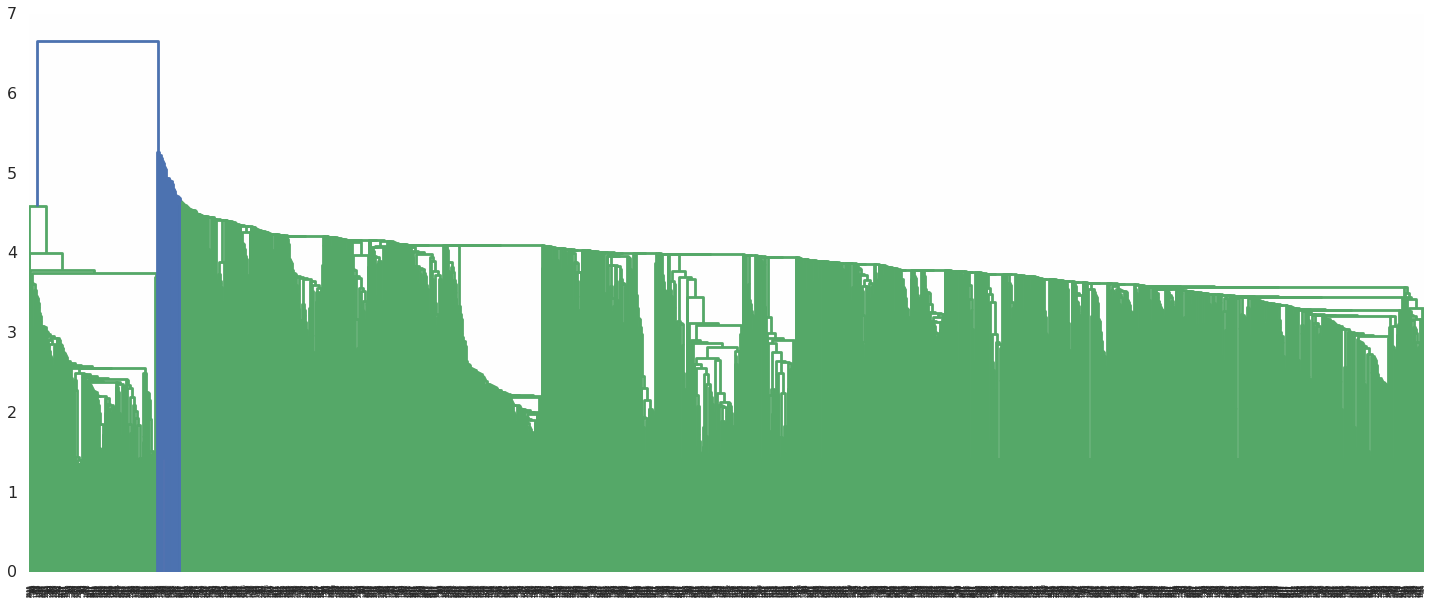

In [172]:
fig = plt.figure(figsize=(25, 10))
dn = shc.dendrogram(Z)
plt.show()